In [1]:
import csv
import re
import sys
import operator
import os
import numpy as np
from pprint import pprint
import json
import math
from operator import itemgetter
import urllib.request
import urllib.parse

import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from IPython.core.debugger import Tracer; debug_here = Tracer()

csv.field_size_limit(sys.maxsize)

131072

In [2]:
# Open JSON files of editor lists
filepath = '/home/michael/school/cprose_research/wp/wikipedia/data/editor_citationbias_novandal.json'
with open(filepath) as f:
    novandal = json.load(f)
print("No vandal, normalized")
pprint(novandal[:5])
pprint(novandal[-5:])
print()

filepath = '/home/michael/school/cprose_research/wp/wikipedia/data/editor_citationbias.json'
with open(filepath) as f:
    allcit= json.load(f)
print("All pages, normalized")
pprint(allcit[:5])
pprint(allcit[-5:])
print()

filepath = '/home/michael/school/cprose_research/wp/wikipedia/data/editor_citationbias_norv.json'
with open(filepath) as f:
    norv = json.load(f)
print("No reverts, normalized")
pprint(norv[:5])
pprint(norv[-5:])
print()

No vandal, normalized
[['Sean.hoyland', [19, -2.355610459600746]],
 ['Nableezy', [-104, -1.8223393963318941]],
 ['Abie the Fish Peddler', [-19, -1.6010607263934813]],
 ['Nishidani', [-12, -1.2533425142943913]],
 ['Wickey-nl', [-51, -1.2183881823737506]]]
[['Ynhockey', [144, 4.228355878420641]],
 ['GHcool', [180, 5.305525828963571]],
 ['Reenem', [396, 7.622056229052159]],
 ['Gilabrand', [259, 7.7079919172824685]],
 ['Wikifan12345', [263, 9.635001851722947]]]

All pages, normalized
[['Sean.hoyland', [26, -2.310973575634345]],
 ['Nableezy', [-112, -1.8609518365232816]],
 ['Abie the Fish Peddler', [-19, -1.6010607263934813]],
 ['Nishidani', [-12, -1.2533425142943913]],
 ['Wickey-nl', [-51, -1.2183881823737506]]]
[['Ynhockey', [144, 4.228355878420641]],
 ['GHcool', [180, 5.305525828963571]],
 ['Reenem', [396, 7.622056229052159]],
 ['Gilabrand', [259, 7.7079919172824685]],
 ['Wikifan12345', [263, 9.635001851722947]]]

No reverts, normalized
[['Abie the Fish Peddler', [-19, -1.601060726393481

In [42]:
# See spread Israeli/Palestinian in novandal list
israelis = [p for p in novandal if p[1][1] > 0]
print("Israelis", len(israelis))

pals = [p for p in novandal if p[1][1] < 0]
print("Palestinians", len(pals))

print(len(novandal))

Israelis 3454
Palestinians 3807
204786


In [4]:
# See a particular user's score
[row for row in novandal if row[0] == 'Ashley kennedy3']

[['Ashley kennedy3', [9, 2.2766166459717683]]]

In [5]:
# Examine a user's top citation changes

user = 'Ashley kennedy3'
csvpath = '/home/michael/school/cprose_research/wp/wikipedia/data/citations_reverts.csv'

user_citations = []

with open(csvpath, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    prev_isr = 0
    prev_pal = 0
    prev_artname = ''
    for i, row in enumerate(reader):
        #if i % 100000 == 0:
            #print(i/1000, 'k')
        
        artname = row[0]
        editor = row[2]
        isrc = int(row[4])
        palc = int(row[5])
        neutc = int(row[6])
        editlen = int(row[7])
        mdf5 = int(row[8])
        rvcomment = int(row[9])
        rv = max(mdf5, rvcomment)
        rvv = int(row[10])
        
        if editor == user:
            if artname == prev_artname:
                change_val = (isrc - prev_isr) - (palc - prev_pal)
            else: # if created the article, add their citations
                change_val = isrc-palc
            if change_val != 0:
                if editlen > 2:
                    change_valnorm = change_val/editlen
                else:
                    change_valnorm = 0

                # Screen out vandalism
                if not rvv:
                    user_citations.append(row + [change_val] + [change_valnorm])

        #print(i, ts, len(citations), 'i:{:d}'.format(len(isrc)), 'p:{:d}'.format(len(palc)), 'n:{:d}'.format(len(neutc)), editor)
        prev_isr = isrc
        prev_pal = palc
        prev_artname = artname

user_citations_pal = sorted(user_citations, key=itemgetter(12))
user_citations_isr = list(reversed(sorted(user_citations, key=itemgetter(12))))
pprint(user_citations_pal[:3])
print()
pprint(user_citations_isr[:3])

[['First Intifada',
  '2008-08-30 07:06:30',
  'Ashley kennedy3',
  '',
  '3',
  '2',
  '51',
  '3',
  '0',
  '0',
  '0',
  -1,
  -0.3333333333333333],
 ['Beit Jala',
  '2008-07-01 03:39:35',
  'Ashley kennedy3',
  '/* Christian-Muslim tension */',
  '10',
  '0',
  '6',
  '36',
  '0',
  '0',
  '0',
  -8,
  -0.2222222222222222],
 ['As-Samu',
  '2008-07-19 16:46:10',
  'Ashley kennedy3',
  '/* Eshael */',
  '0',
  '1',
  '4',
  '5',
  '0',
  '0',
  '0',
  -1,
  -0.2]]

[['Gilad Shalit',
  '2008-08-12 06:05:40',
  'Ashley kennedy3',
  '/* Diplomatic efforts */',
  '8',
  '1',
  '31',
  '3',
  '0',
  '0',
  '0',
  1,
  0.3333333333333333],
 ['Ami Ayalon',
  '2008-05-25 07:35:59',
  'Ashley kennedy3',
  '',
  '3',
  '0',
  '3',
  '3',
  '0',
  '0',
  '0',
  1,
  0.3333333333333333],
 ['Gaza Strip',
  '2008-08-05 09:47:58',
  'Ashley kennedy3',
  '/* Hamas control (2007-present) */',
  '7',
  '4',
  '32',
  '4',
  '0',
  '0',
  '0',
  1,
  0.25]]


In [46]:
# Examine deeper in no vandal list
cutoff_isr = round(len(israelis)/10)
cutoff_pal = round(len(pals)/10)
print(cutoff_isr)
print(cutoff_pal)

n_editors = 5

pprint(novandal[cutoff_pal:cutoff_pal+5])
pprint(novandal[-1*cutoff_isr-5:-1*cutoff_isr])

345
381
[['Kevin McE', [-1, -0.058823529411764705]],
 ['24.184.138.82', [-1, -0.058823529411764705]],
 ['Czypcamayoc', [0, -0.05877034358047016]],
 ['BothHandsBlack', [-4, -0.05832021006599995]],
 ['Gudeldar', [-7, -0.05814479007977459]]]
[['Salamurai', [2, 0.13575285374065862]],
 ['Pioneeranomoly', [4, 0.13614718614718613]],
 ['Tpbradbury', [3, 0.13630949424851957]],
 ['Ammar shaker', [2, 0.13675213675213674]],
 ['TheYmode', [8, 0.13746521673570763]]]


In [14]:
user_citations[:15]

[['Nablus',
  '2008-07-13 10:50:59',
  'Ashley kennedy3',
  '',
  '2',
  '1',
  '109',
  '0',
  '0',
  '0',
  '0',
  0,
  0],
 ['History of the Israeli–Palestinian conflict',
  '2009-03-20 22:40:14',
  'Ashley kennedy3',
  'under zionism',
  '10',
  '0',
  '111',
  '0',
  '0',
  '0',
  '0',
  0,
  0],
 ['History of the Israeli–Palestinian conflict',
  '2009-03-21 07:11:49',
  'Ashley kennedy3',
  '/* Paris Peace Conference and the League of Nations */ chronology',
  '10',
  '0',
  '115',
  '0',
  '0',
  '0',
  '0',
  0,
  0],
 ['1982 Lebanon War',
  '2008-08-12 09:20:24',
  'Ashley kennedy3',
  '',
  '1',
  '0',
  '32',
  '0',
  '0',
  '0',
  '0',
  0,
  0],
 ['Mount Scopus',
  '2008-06-17 10:01:18',
  'Ashley kennedy3',
  'Putting convoy under hospital where it belongs',
  '2',
  '0',
  '15',
  '0',
  '0',
  '0',
  '0',
  0,
  0],
 ['Mount Scopus',
  '2008-06-30 02:55:04',
  'Ashley kennedy3',
  '',
  '2',
  '0',
  '14',
  '0',
  '0',
  '0',
  '0',
  0,
  0],
 ['Mount Scopus',
  '2008

/usr/lib/python3/dist-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


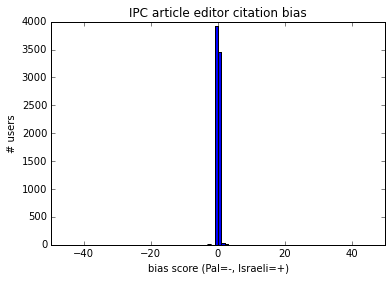

In [8]:
%matplotlib inline

# See distribution of all users' bias based on citation bias without vandalism, normalized for edit length
counts = np.asarray([ed[1][1] for ed in novandal if ed[1][1] != 0])
#plt.hist(counts, bins=range(min(counts), max(counts) + 1, 1))
plt.hist(counts, bins=range(math.floor(min(counts)), math.ceil(max(counts)), 1))
plt.title("IPC article editor citation bias")
plt.xlabel("bias score (Pal=-, Israeli=+)")
plt.ylabel("# users")
plt.xlim(-15,15)
fig = plt.gcf()
fig.show()

In [25]:
counts = np.asarray([ed[1][1] for ed in novandal if ed[1][1] != 0])
bin_range = range(math.floor(min(counts)), math.ceil(max(counts)), 1)
print(bin_range)

range(-1282, 18165)


In [2]:
# Get bot list
bots = []
cnum = ""
done = False

# Get bot category page
category_base_url = "https://en.wikipedia.org/w/api.php?" + \
    "action=query&" +  \
    "list=categorymembers&" + \
    "format=json&" + \
    "cmtitle=Category%3A{:s}&" +  \
    "cmprop=title&" + \
    "cmlimit=500" + \
    "&cmcontinue={:s}"
    
while not done:
    category_url = category_base_url.format(urllib.parse.quote("All_Wikipedia_bots"), cnum)
    #print(category_url)

    page =  urllib.request.urlopen(category_url).read().decode('utf-8')
    #print(page)

    # Extract bot names
    botsp = re.findall(r'"User\:(?P<username>[\w\ /\.]*)"\}', page)
    botsp = [re.sub(r'/.*', '', ed) for ed in botsp]
    #print(botsp[:10])
    bots += botsp
    print(len(bots))

    # Get continue number
    #cnum = re.search(r'cmcontinue":"(?P<cnum>[^"]*)"', page)
    cnum = re.search(r'cmcontinue":"([^"]*)"', page)
    if cnum:
        cnum = cnum.group(1)
        print(cnum)
    else:
        done = True

# Add other bots
other_bots = ['SmackBot']
bots += other_bots
len(bots)

441
page|4543484f424f54|12093362
872
page|4d49535a41424f54|4602007
1308
page|5446412050524f544543544f5220424f54|39345854
1478


1479

In [3]:
# Get editor lists from accumulated csv

csvpath = '/home/michael/school/cprose_research/wp/wikipedia/data/citations_reverts.csv'

editor_citations = defaultdict(tuple)
editor_citations_novandal = defaultdict(tuple)
editor_citations_novandal_contrib = defaultdict(tuple)
editor_citations_norv = defaultdict(tuple)

with open(csvpath, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    prev_isr = 0
    prev_pal = 0
    prev_artname = ''
    for i, row in enumerate(reader):
        #if i % 100000 == 0:
            #print(i/1000, 'k')
        
        change_val = 0
        change_valnorm = 0.0
        artname = row[0]
        editor = row[2]
        #if editor == 'DominicBuch':
        #    debug_here()
        isrc = int(row[4])
        palc = int(row[5])
        neutc = int(row[6])
        editlen = int(row[7])
        mdf5 = int(row[8])
        rvcomment = int(row[9])
        rv = max(mdf5, rvcomment)
        rvv = int(row[10])
        if artname == prev_artname:
            change_val = (isrc - prev_isr) - (palc - prev_pal)
        else: # if created the article, add their citations
            change_val = isrc-palc
        if editlen > 2:
            change_valnorm = change_val/editlen
        
        if editor not in bots:
            # Save to editor_citations
            if editor_citations[editor]:
                prev = editor_citations[editor]
                editor_citations[editor] = [prev[0] + change_val, prev[1] + change_valnorm]
            else:
                editor_citations[editor] = [change_val, change_valnorm]

            # Screen out vandalism
            if not rvv:
                if editor_citations_novandal[editor]:
                    prev = editor_citations_novandal[editor]
                    editor_citations_novandal[editor] = [prev[0] + change_val, prev[1] + change_valnorm]
                else:
                    editor_citations_novandal[editor] = [change_val, change_valnorm]
                if change_val != 0:
                    if editor_citations_novandal_contrib[editor]:
                        prev = editor_citations_novandal_contrib[editor]
                        editor_citations_novandal_contrib[editor] = [prev[0] + change_val, prev[1] + change_valnorm]
                    else:
                        editor_citations_novandal_contrib[editor] = [change_val, change_valnorm]

            # Screen out reverts
            if not rv:
                if editor_citations_norv[editor]:
                    prev = editor_citations_norv[editor]
                    editor_citations_norv[editor] = [prev[0] + change_val, prev[1] + change_valnorm]
                else:
                    editor_citations_norv[editor] = [change_val, change_valnorm]
        
        #print(i, ts, len(citations), 'i:{:d}'.format(len(isrc)), 'p:{:d}'.format(len(palc)), 'n:{:d}'.format(len(neutc)), editor)
        prev_isr = isrc
        prev_pal = palc
        prev_artname = artname

print(len(editor_citations))
print(len(editor_citations_novandal))
print(len(editor_citations_novandal_contrib))
print(len(editor_citations_norv))

204807
204601
7400
196205


In [4]:
# Sort editor lists

print("No vandal list norm")
sorted_editor_citations_novandal_norm = sorted(editor_citations_novandal.items(), key=lambda x: x[1][1])
pprint(sorted_editor_citations_novandal_norm[:10])
pprint(sorted_editor_citations_novandal_norm[-10:])
print()

print("No vandal list contrib norm")
sorted_novandal_contrib = sorted(editor_citations_novandal_contrib.items(), key=lambda x: x[1][1])
pprint(sorted_novandal_contrib[:10])
pprint(sorted_novandal_contrib[-10:])
print()

print("No vandal list sum")
sorted_editor_citations_novandal_sum = sorted(editor_citations_novandal.items(), key=lambda x: x[1][0])
pprint(sorted_editor_citations_novandal_sum[:10])
pprint(sorted_editor_citations_novandal_sum[-10:])
print()

sorted_editor_citations_sum = sorted(editor_citations.items(), key=lambda x: x[1][0])
#pprint(sorted_editor_citations_sum[:5])
#pprint(sorted_editor_citations_sum[-5:])
#print()

sorted_editor_citations_norm = sorted(editor_citations.items(), key=lambda x: x[1][1])
#pprint(sorted_editor_citations_norm[:5])
#pprint(sorted_editor_citations_norm[-5:])
#print()

sorted_editor_citations_norv_sum = sorted(editor_citations_norv.items(), key=lambda x: x[1][0])
#pprint(sorted_editor_citations_norv_sum[:5])
#pprint(sorted_editor_citations_norv_sum[-5:])
#print()

sorted_editor_citations_norv_norm = sorted(editor_citations_norv.items(), key=lambda x: x[1][1])
#pprint(sorted_editor_citations_norv_norm[:5])
#pprint(sorted_editor_citations_norv_norm[-5:])
#print()

No vandal list norm
[('Al Ameer son', [-255, -2.920692136214118]),
 ('Sean.hoyland', [12, -2.3617102353106882]),
 ('Nableezy', [-107, -1.8442669192123466]),
 ('Abie the Fish Peddler', [-19, -1.6010607263934813]),
 ('Wickey-nl', [-64, -1.4164836198031896]),
 ('Nishidani', [-13, -1.254168960575383]),
 ('Zero0000', [-75, -1.251400449977085]),
 ('Padres Hana', [-27, -1.1721355304227936]),
 ('JaapBoBo', [-106, -1.0680315364420365]),
 ('Screen stalker', [-5, -0.7660883008277674])]
[('Shamir1', [123, 2.4816499035988797]),
 ('Tewfik', [250, 2.6764388184985273]),
 ('Jalapenos do exist', [312, 2.7629799082701747]),
 ('Jiujitsuguy', [150, 2.867334971621261]),
 ('TheCuriousGnome', [135, 3.1400784488408733]),
 ('Ynhockey', [145, 4.186494406559169]),
 ('GHcool', [180, 5.305525828963571]),
 ('Reenem', [396, 7.622056229052159]),
 ('Gilabrand', [258, 7.680214139504691]),
 ('Wikifan12345', [262, 9.492144708865805])]

No vandal list norm
[('Al Ameer son', [-255, -2.920692136214118]),
 ('Sean.hoyland', [1

In [5]:
# Save editor lists
with open('/home/michael/school/cprose_research/wp/wikipedia/data/editor_citationbias.json', 'w') as f:
    json.dump(sorted_editor_citations_norm, f)
    
with open('/home/michael/school/cprose_research/wp/wikipedia/data/editor_citationbias_novandal.json', 'w') as f:
    json.dump(sorted_editor_citations_novandal_norm, f)
    
with open('/home/michael/school/cprose_research/wp/wikipedia/data/editor_citationbias_novandal_contrib.json', 'w') as f:
    json.dump(sorted_novandal_contrib, f)
    
with open('/home/michael/school/cprose_research/wp/wikipedia/data/editor_citationbias_norv.json', 'w') as f:
    json.dump(sorted_editor_citations_norv_norm, f)